In [46]:
import os
import glob

import math
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy import linalg as LA
from scipy.signal import correlate2d
from scipy.signal import fftconvolve

dir1 = '../images/ImageMosaicing/'
savedir='../opImages/ImageMosiacing'

## Image Mosiacing

## Question 1.2

In [47]:
# Finding the homography matrix for the two sample points 
# Question 2
def homography(pts1,pts2):
    
    pt1 = np.insert(pts1,2,1,axis=1)
    wp = np.stack((pt1,pt1),2).transpose(0,2,1).reshape(2*pt1.shape[0],3)
    wp_mat = np.hstack((wp,wp,wp))
    tmp_mat = np.tile(np.hstack((np.vstack((-1*np.ones(3),np.zeros(3))),np.vstack((np.zeros(3),-1*np.ones(3))))),(pts2.shape[0],1))
    im_mat = np.hstack((tmp_mat,np.tile(pts2.ravel()[:,None],(1,3))))
    A = im_mat*wp_mat
    
    U,D,V = LA.svd(A)
    h = V[-1,:]
    H = h.reshape(3,3)
    return H/H[2,2]

In [48]:
# Question 2
# Finding l2norm between the two points used to calculation in ransac
def l2normError(pts1,pts2,M):
    
    proj_pts = M.dot(np.insert(pts1,2,1,axis=1).T)
    proj_pts = (proj_pts/proj_pts[-1,:])[:2,:].T
    return np.sum(LA.norm(proj_pts-pts2,axis=1))/pts1.shape[0]

In [49]:
# Question 2
# Ransac function to determine the best homography matrix 
def ransac(pts1,pts2,sample_sz = 30,max_iter=1000):
    '''RANSAC method for finding homography matrix'''
    errr = 1e6
    H0 = np.empty((3,3))
    for i in range(max_iter):
        ind = np.random.choice(pts1.shape[0],sample_sz,replace = False)
        pt1 = pts1[ind,:]
        pt2 = pts2[ind,:]
        H = homography(pt1,pt2)
        err = l2normError(pt1,pt2,H)
        if(err<errr):
            errr = err
            H0 = H
    return H0,errr

## Question 1.4

In [50]:
# Stitching function to stitch the images based on the key points generated 
def stitchImages(im1,im2,method = 1):
    '''Stitch two images by matching sift features of two images'''
    sift = cv2.SIFT_create()
    key1, des1 = sift.detectAndCompute(cv2.cvtColor(im1, cv2.COLOR_BGR2GRAY),None)
    key2, des2 = sift.detectAndCompute(cv2.cvtColor(im2, cv2.COLOR_BGR2GRAY),None)
    
    bf = cv2.BFMatcher()
    matches = bf.match(des1,des2)
    
    numMatches = 100
    matches = sorted(matches, key = lambda x:x.distance)[:numMatches]
    
    pts1 = np.float32([ key1[m.queryIdx].pt for m in matches ]).reshape(-1,2)
    pts2 = np.float32([ key2[m.trainIdx].pt for m in matches ]).reshape(-1,2)
    
    H,_ = ransac(pts1,pts2)
    
    
    
    if(method==1):
        h1, w1 = im2.shape[:2]
        h2, w2 = im1.shape[:2]
        c1 = np.float32([[0, 0], [0, h1], [w1, h1], [w1, 0]]).reshape(-1, 1, 2)
        c2 = np.float32([[0, 0], [0, h2], [w2, h2], [w2, 0]]).reshape(-1, 1, 2)
        c2_ = cv2.perspectiveTransform(c2, H)
        c = np.concatenate((c1, c2_), axis=0)

        [xmin, ymin] = np.int32(c.min(axis=0).ravel() - 0.5)
        [xmax, ymax] = np.int32(c.max(axis=0).ravel() + 0.5)
        t = [-xmin, -ymin]

        Ht = np.array([[1, 0, t[0]], [0, 1, t[1]], [0, 0, 1]])

        out = cv2.warpPerspective(im1, Ht.dot(H), (xmax-xmin, ymax-ymin))
        out[t[1]:h1+t[1], t[0]:w1+t[0]] = im2
    elif(method==2):
        out = cv2.warpPerspective(im2,np.linalg.inv(H),(im1.shape[1]+im2.shape[1],im1.shape[0]))
        out[0:im1.shape[0],0:im1.shape[1],:] = im1
        r = np.where(np.sum(out,(0,2)) == 0)[0]
        if(np.size(r)!=0):
            out = out[:,0:r[0],:]
    else: # method 3
        out = cv2.warpPerspective(im2,np.linalg.inv(H),(im1.shape[1],im2.shape[0]+im1.shape[0]))
        out[0:im1.shape[0],0:im1.shape[1],:] = im1
        r = np.where(np.sum(out,(1,2)) == 0)[0]
        if(np.size(r)!=0):
            out = out[0:r[0],:,:]
    return out

# Question 1: Experiments

## Image set:1

In [51]:
im1 = cv2.imread(dir1 + str('1_1') + str('.jpg'))
im2 = cv2.imread(dir1 + str('1_2') + str('.jpg'))
im3 = cv2.imread(dir1 + str('1_3') + str('.jpg'))
im4 = cv2.imread(dir1 + str('1_4') + str('.jpg'))

In [52]:
# Stitching the images two at a time in order. 
finalIm1 = stitchImages(im1,
                        stitchImages(im2,
                                     stitchImages(im3,im4,method=2),
                                     method=2),
                        method=2)

True

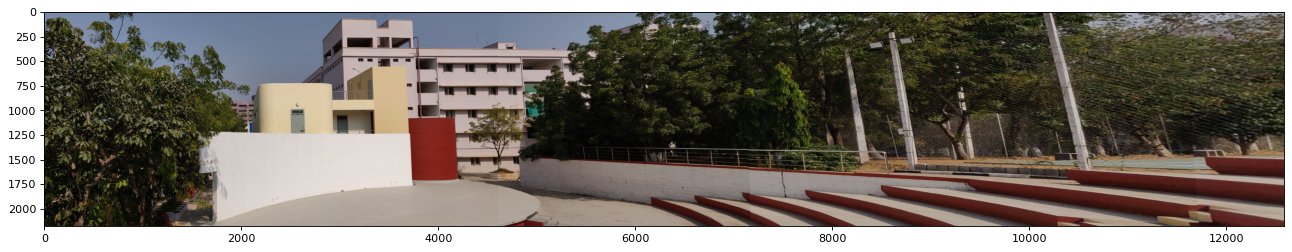

In [53]:
fig = plt.figure(figsize=(20,20),dpi=80)
finalIm1 = cv2.cvtColor(finalIm1,cv2.COLOR_BGR2RGB)
plt.imshow(finalIm1)
cv2.imwrite(savedir+'1.jpg',finalIm1)

## Image set:2

In [54]:
im1 = cv2.imread(dir1 + str('2_1') + str('.png'))
im2 = cv2.imread(dir1 + str('2_2') + str('.png'))
im3 = cv2.imread(dir1 + str('2_3') + str('.png'))
im4 = cv2.imread(dir1 + str('2_4') + str('.png'))
im5 = cv2.imread(dir1 + str('2_5') + str('.png'))
im6 = cv2.imread(dir1 + str('2_6') + str('.png'))

In [55]:
finalIm2 = stitchImages(stitchImages(
    stitchImages(
        im4,stitchImages(
            stitchImages(im1,im2),im3)),im5),im6)

True

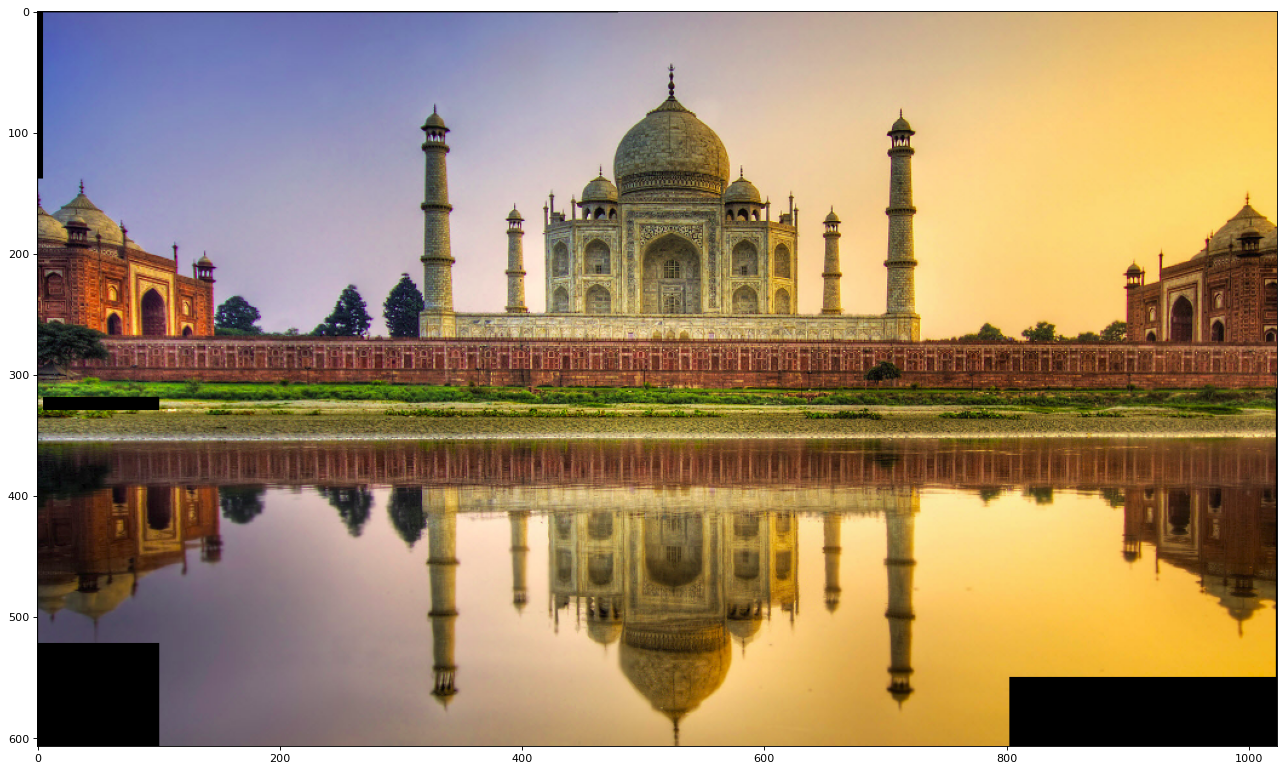

In [56]:
fig = plt.figure(figsize=(20,20),dpi=80)
finalIm2 = cv2.cvtColor(finalIm2,cv2.COLOR_BGR2RGB)
plt.imshow(finalIm2)
cv2.imwrite(savedir+'2.jpg',finalIm2)

## Image set 3

In [57]:
im1 = cv2.imread(dir1 + str('3_1') + str('.png'))
im2 = cv2.imread(dir1 + str('3_2') + str('.png'))

In [58]:
finalIm3 = stitchImages(im1,im2,method=2)

True

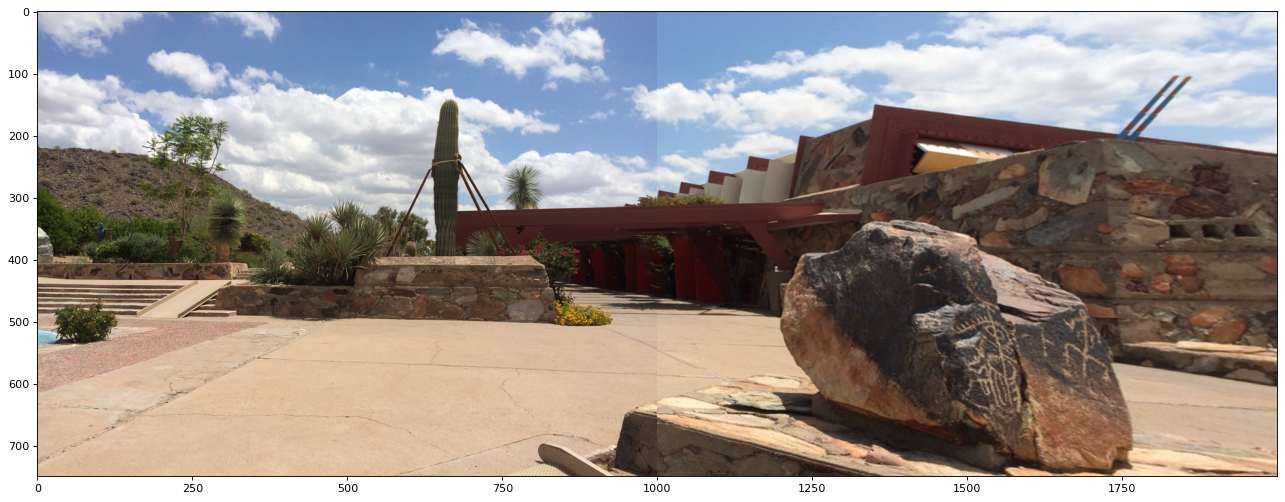

In [59]:
fig = plt.figure(figsize=(20,20),dpi=80)
finalIm3 = cv2.cvtColor(finalIm3,cv2.COLOR_BGR2RGB)
plt.imshow(finalIm3)
cv2.imwrite(savedir+'3.jpg',finalIm3)

## Image set:4

In [60]:
im1 = cv2.imread(dir1 + str('4_1') + str('.jpg'))
im2 = cv2.imread(dir1 + str('4_2') + str('.jpg'))

In [61]:
finalIm4 = stitchImages(im1,im2,method=2)

True

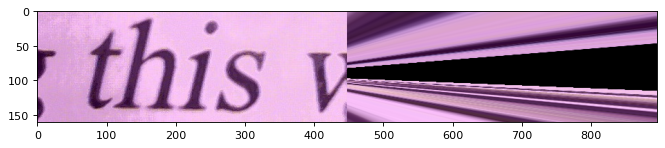

In [62]:
fig = plt.figure(figsize=(10,10),dpi=80)
finalIm4 = cv2.cvtColor(finalIm4,cv2.COLOR_BGR2RGB)
plt.imshow(finalIm4)
cv2.imwrite(savedir+'4.jpg',finalIm4)

## Image set:5

In [63]:
im1 = cv2.imread(dir1 + str('5_1') + str('.jpg'))
im2 = cv2.imread(dir1 + str('5_2') + str('.jpg'))
im3 = cv2.imread(dir1 + str('5_3') + str('.jpg'))
im4 = cv2.imread(dir1 + str('5_4') + str('.jpg'))

In [64]:
finalIm5 = stitchImages(stitchImages(im1,im2,method=2),
                        im4)

True

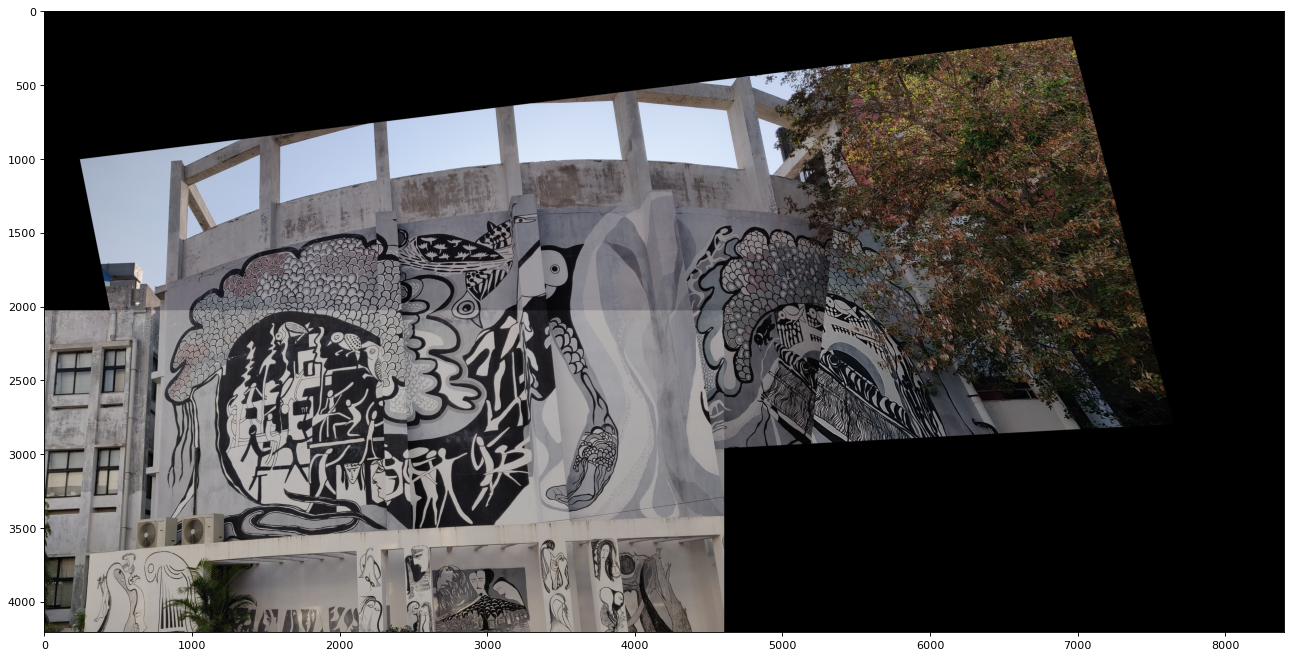

In [65]:
fig = plt.figure(figsize=(20,20),dpi=80)
finalIm5 = cv2.cvtColor(finalIm5,cv2.COLOR_RGB2BGR)
plt.imshow(finalIm5)
cv2.imwrite(savedir+'5.jpg',finalIm5)

## Question 1.7, Image set:6

In [66]:
im1= cv2.cvtColor(cv2.imread(dir1+str('6_1')+str('.jpg')),cv2.COLOR_BGR2RGB)
im2=cv2.cvtColor(cv2.imread(dir1+str('6_2')+str('.jpg')),cv2.COLOR_BGR2RGB)

In [67]:
finalImage6=stitchImages(im1,im2)

True

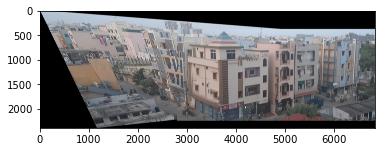

In [68]:
plt.imshow(finalImage6)
cv2.imwrite(savedir+'6.jpg',finalImage6)